# Como fazer um mapa de velocidade geostrófica climatológica (WOA13)

### Neste tutorial você aprenderá: 

1. Ler dados climatológicos do WOA13 
2. Ler dados em NetCDF
3. Acessar um serviço OpenDap
4. Calcular Geopotencial e Função de Corrente
5. Calcular campo vetorial de velocidade a partir de Função de Corrente
6. Baixar dados de batimetria
7. Plotar campo climatológico de corrente geostrófica

Primeiramente vamos importar os módulos que iremos usar:

In [2]:
import matplotlib.pyplot as plt
import seawater as sw
from OceanLab.DYN import psi2uv
from mpl_toolkits.basemap import Basemap # módulo de mapas
import cmocean.cm as cm
from OceanLab.utils import ETOPOget
from OceanLab.utils import save_pickle,load_pickle
from pydap.client import open_url
import numpy as np
from netCDF4 import Dataset

Aqui vamos pré-configurar o `matplotlib` para negrito com tamanho 15:

In [3]:
##########################################################################
# CONFIGURANDO MATPLOTLIB RC
##########################################################################

import matplotlib as mpl
font = {'weight' : 'bold',
        'size'   : 15}

mpl.rc('font', **font)

Aqui vamos definir o endereço base para o serviço OpenDap que iremos acessar:

In [4]:
##########################################################################
# DEFININDO CAMINHOS
##########################################################################

base = 'http://apdrc.soest.hawaii.edu'
adds = base+'/dods/public_data/WOA/WOA13/0.25_deg/annual/'

Aqui iremos definir algumas constantes, como os limites do nosso mapa e o nível de referência para método dinâmico:

In [5]:
##########################################################################
# DEFININDO CONSTANTES
##########################################################################

lati,latf = -20,-7
loni,lonf = -41,-30

# nível de referência
reflev = 46 #1000 metros nos dados
# nível para plotar
pltlev = 0 #superfície

Aqui nós lemos os nossos dados climatológicos:

In [6]:
##########################################################################
# LENDO DADOS DE CLIMATOLOGIA
##########################################################################

# função lambda de leitura dos dados
WOA13     = lambda prop:Dataset(adds+prop)
# lendo dados do servidor opendap
TDAT,SDAT = WOA13('temp'),WOA13('salt')

# definindo latitude e longitude
lev,lon,lat = TDAT['lev'][:],TDAT['lon'][:],TDAT['lat'][:] # [:] seleciona todos os valores

Aqui nós fazemos um `subset` nos dados para a região de interesse:

In [7]:
# condições para subset dos dados
condlon = (lon>loni)&(lon<lonf)
condlat = (lat>lati)&(lat<latf)

# subset dos dados
TEMP = TDAT['tan'][:,:,condlat,:][:,:,:,condlon]
SALT = SDAT['san'][:,:,condlat,:][:,:,:,condlon]

lon,lat = lon[condlon],lat[condlat]

_Apesar de serem dados climatológicos anuais, ainda se mantém o padrão de possuir a dimensão tempo._

Aqui nós removemos a máscara e reduzimos a dimensão dos dados:

In [8]:
# criando grid horizontal
LON,LAT = np.meshgrid(lon,lat)

# lendo dados de temperatura
TEMPval,TEMPmask = TEMP.data,TEMP.mask
# deflag dos dados de temperatura
TEMPval[TEMPmask] = np.nan
# reduzindo uma dimensão
TEMPval = np.squeeze(TEMPval)

# lendo dados de salinidade
SALTval,SALTmask = SALT.data,SALT.mask
# deflag dos dados de salinidade
SALTval[SALTmask] = np.nan
# reduzindo uma dimensão
SALTval = np.squeeze(SALTval)

Aqui nós calculamos o geopotencial utilizando a função `gpan` do pacote `seawater`, para fazer isso, precisamos juntar as duas dimensões de espaço _(latitude e longitude)_ em uma só, com a função `reshape`. Para referenciar, nós removemos o geopotencial do nível de referência e ao fim, como o nível de referência está abaixo do nível de plot, multiplicamos a -1 para corrigir o sentido da integral.

In [9]:
##########################################################################
# CALCULANDO GEOPOTENCIAL
##########################################################################

# extraindo dimensões da array de temperatura
L,M,N = TEMPval.shape
# criando array de levels prof X dimensão_horizontal
LEV = np.array([lev,]*M*N)
# transpondo a array LEV
LEV = LEV.T

# calculando geopotencial com arrays prof X dimensão_horizontal
GPAN = sw.gpan(SALTval.reshape(L,M*N),TEMPval.reshape(L,M*N),LEV)
# corrigindo formato
GPAN = GPAN.reshape(L,M,N)

# referenciando
GPANref = (GPAN-GPAN[reflev,:,:])
# corrigindo sentido da integral
GPANref = -GPANref

Aqui calculamos a função de corrente geostrófica para a latitude média e calculamos o campo vetorial de velocidade usando a função `psi2uv` do pacote `OceanLab`:

In [10]:
##########################################################################
# CALCULANDO FUNÇÃO DE CORRENTE E CAMPO DE VELOCIDADE
##########################################################################

# calculando função de corrente
PSI = GPANref/sw.f(lat.mean())

# selecionando apenas nível para plotar
PSIplot = PSI[pltlev,:,:]
# deixando valor mínimo como 0
PSIplot = PSIplot-np.nanmin(PSIplot)

# calculando campo de velocidade
U,V = psi2uv(LON,LAT,PSIplot)

Aqui nós lemos dados batimétricos da ETOPO usando a função `ETOPOget` do pacote `OceanLab`:

In [11]:
##########################################################################
# LENDO DADOS DE BATIMETRIA
##########################################################################

BDATA = ETOPOget(loni,lonf,lati,latf)

blon,blat = BDATA['lon'][:],BDATA['lat'][:]
bLON,bLAT = np.meshgrid(blon,blat)
BAT = BDATA['Band1'][:]

Aqui vamos plotar a figura. Para isso iremos usar um pacote chamado `basemap`, definindo projeção e limites do mapa.
Criaremos linhas de meridianos, paralelos e escala. Depois plotaremos um mapa de contornos de Função de Corrente usando a função `contourf` do objeto de mapa que criamos. Usamos também um `colormap` específico para Oceanografia https://matplotlib.org/cmocean/. Plotaremos também setas para representar as velocidades e a também a linha batimétrica.

/home/iury/Programs/anaconda3/envs/oceano/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3542: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  xx = x[x.shape[0]/2,:]


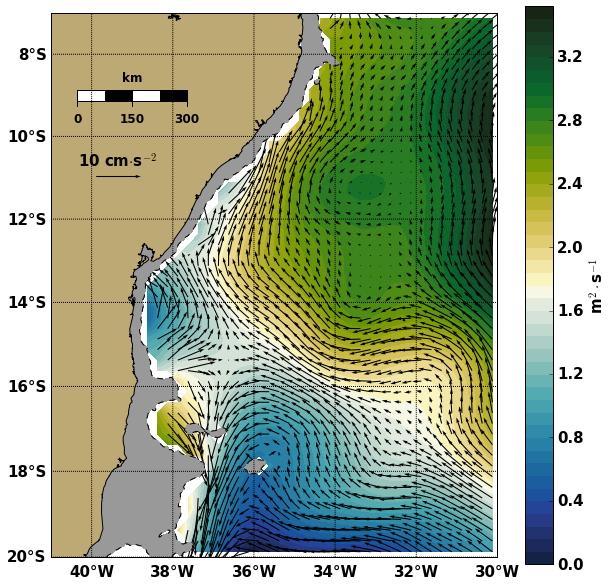

In [12]:
##########################################################################
# PLOTANDO FIGURA
##########################################################################

# Cria uma figura
plt.figure(figsize=(10,10)) #aqui definimos um tamanho maior para a figura
# Cria o mapa
M = Basemap(llcrnrlon=loni, llcrnrlat=lati,
            urcrnrlon=lonf, urcrnrlat=latf,
            resolution='i',projection='merc')

# Preenchimento dos continentes
M.fillcontinents(color='#BDA973');
# Linhas de costa
M.drawcoastlines(linewidth=1);

# Meridianos e Paralelos
lbs=[1, 0, 0, 1]
M.drawmeridians(range(-180,180,2),labels=lbs);
M.drawparallels(range(-90,90,2),labels=lbs);

# Escala
M.drawmapscale(-39,-9,-35,-14,300,barstyle='fancy',fontsize=12);


# contornos de função de corrente
C = M.contourf(LON,LAT,PSIplot*1e-4,50,vmin=0,vmax=3.5,cmap=cm.delta,latlon=True)
# colorbar
cbar = plt.colorbar(C)
# unidades da colorbar
cbar.ax.set_ylabel(r'm$^{2}\cdot$s$^{-1}$',fontsize=15,fontweight='bold')

# plotando campo de velocidade
Q = M.quiver(LON,LAT,U,V,scale=1,latlon=True)

# configuração da fonte do quiverkey
fontquiver = dict(weight= 'bold',size=15)
# plotando quiverkey
plt.quiverkey(Q,0.15,0.7,0.1,label=r'10 cm$\cdot$s$^{-2}$',fontproperties=fontquiver)

# contornos preenchidos de batimetria em cinza
M.contourf(bLON,bLAT,BAT,[-1200,0],colors='0.6',latlon=True)
# linha de contorno de 1200 metros preta
M.contour(bLON,bLAT,BAT,[-1200],colors='k',latlon=True)

Aqui nós podemos salvar a figura com uma resolução escolhida:

In [ ]:

plt.savefig('./'+'l2.png',dpi=200)

Ao fim, temos o código completo abaixo:

In [1]:
# Por fins didáticos a rotina foi mostrada de forma fragmentada
# Na prática, a rotina completa segue a seguir:

##########################################################################
# IMPORTANDO OS MÓDULOS
##########################################################################
import matplotlib.pyplot as plt
import seawater as sw
from OceanLab.DYN import psi2uv
from mpl_toolkits.basemap import Basemap # módulo de mapas
import cmocean.cm as cm
from OceanLab.utils import ETOPOget
from OceanLab.utils import save_pickle,load_pickle
from pydap.client import open_url
import numpy as np
from netCDF4 import Dataset

##########################################################################
# CONFIGURANDO MATPLOTLIB RC
##########################################################################

import matplotlib as mpl
font = {'weight' : 'bold',
        'size'   : 15}

mpl.rc('font', **font)

##########################################################################
# DEFININDO CAMINHOS
##########################################################################

base = 'http://apdrc.soest.hawaii.edu'
adds = base+'/dods/public_data/WOA/WOA13/0.25_deg/annual/'

##########################################################################
# DEFININDO CONSTANTES
##########################################################################

lati,latf = -20,-7
loni,lonf = -41,-30

# nível de referência
reflev = 46 #1000 metros nos dados
# nível para plotar
pltlev = 0 #superfície

##########################################################################
# LENDO DADOS DE CLIMATOLOGIA
##########################################################################

# função lambda de leitura dos dados
WOA13     = lambda prop:Dataset(adds+prop)
# lendo dados do servidor opendap
TDAT,SDAT = WOA13('temp'),WOA13('salt')

# definindo latitude e longitude
lev,lon,lat = TDAT['lev'][:],TDAT['lon'][:],TDAT['lat'][:] # [:] seleciona todos os valores

# condições para subset dos dados
condlon = (lon>loni)&(lon<lonf)
condlat = (lat>lati)&(lat<latf)

# subset dos dados
TEMP = TDAT['tan'][:,:,condlat,:][:,:,:,condlon]
SALT = SDAT['san'][:,:,condlat,:][:,:,:,condlon]

lon,lat = lon[condlon],lat[condlat]

# criando grid horizontal
LON,LAT = np.meshgrid(lon,lat)

# lendo dados de temperatura
TEMPval,TEMPmask = TEMP.data,TEMP.mask
# deflag dos dados de temperatura
TEMPval[TEMPmask] = np.nan
# reduzindo uma dimensão
TEMPval = np.squeeze(TEMPval)

# lendo dados de salinidade
SALTval,SALTmask = SALT.data,SALT.mask
# deflag dos dados de salinidade
SALTval[SALTmask] = np.nan
# reduzindo uma dimensão
SALTval = np.squeeze(SALTval)

##########################################################################
# CALCULANDO GEOPOTENCIAL
##########################################################################

# extraindo dimensões da array de temperatura
L,M,N = TEMPval.shape
# criando array de levels prof X dimensão_horizontal
LEV = np.array([lev,]*M*N)
# transpondo a array LEV
LEV = LEV.T

# calculando geopotencial com arrays prof X dimensão_horizontal
GPAN = sw.gpan(SALTval.reshape(L,M*N),TEMPval.reshape(L,M*N),LEV)
# corrigindo formato
GPAN = GPAN.reshape(L,M,N)

# referenciando
GPANref = (GPAN-GPAN[reflev,:,:])
# corrigindo sentido da integral
GPANref = -GPANref

##########################################################################
# CALCULANDO FUNÇÃO DE CORRENTE E CAMPO DE VELOCIDADE
##########################################################################

# calculando função de corrente
PSI = GPANref/sw.f(lat.mean())

# selecionando apenas nível para plotar
PSIplot = PSI[pltlev,:,:]
# deixando valor mínimo como 0
PSIplot = PSIplot-np.nanmin(PSIplot)

# calculando campo de velocidade
U,V = psi2uv(LON,LAT,PSIplot)



##########################################################################
# LENDO DADOS DE BATIMETRIA
##########################################################################

BDATA = ETOPOget(loni,lonf,lati,latf)

blon,blat = BDATA['lon'][:],BDATA['lat'][:]
bLON,bLAT = np.meshgrid(blon,blat)
BAT = BDATA['Band1'][:]
##########################################################################
# PLOTANDO FIGURA
##########################################################################

# Cria uma figura
plt.figure(figsize=(10,10)) #aqui definimos um tamanho maior para a figura
# Cria o mapa
M = Basemap(llcrnrlon=loni, llcrnrlat=lati,
            urcrnrlon=lonf, urcrnrlat=latf,
            resolution='i',projection='merc')

# Preenchimento dos continentes
M.fillcontinents(color='#BDA973');
# Linhas de costa
M.drawcoastlines(linewidth=1);

# Meridianos e Paralelos
lbs=[1, 0, 0, 1]
M.drawmeridians(range(-180,180,2),labels=lbs);
M.drawparallels(range(-90,90,2),labels=lbs);

# Escala
M.drawmapscale(-39,-9,-35,-14,300,barstyle='fancy',fontsize=12);

X,Y = M(LON,LAT)
# contornos de função de corrente
C = M.contourf(X,Y,PSIplot*1e-4,50,vmin=0,vmax=3.5,cmap=cm.delta)
# colorbar
cbar = plt.colorbar(C)
# unidades da colorbar
cbar.ax.set_ylabel(r'm$^{2}\cdot$s$^{-1}$',fontsize=15,fontweight='bold')

# plotando campo de velocidade
Q = M.quiver(LON,LAT,U,V,scale=1,latlon=True)

# configuração da fonte do quiverkey
fontquiver = dict(weight= 'bold',size=15)
# plotando quiverkey
plt.quiverkey(Q,0.15,0.7,0.1,label=r'10 cm$\cdot$s$^{-2}$',fontproperties=fontquiver)

# contornos preenchidos de batimetria em cinza
M.contourf(bLON,bLAT,BAT,[-1200,0],colors='0.6',latlon=True)
# linha de contorno de 1200 metros preta
M.contour(bLON,bLAT,BAT,[-1200],colors='k',latlon=True)
plt.savefig('./'+'l2.png',dpi=200)
